# **Combined Model Approach**

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split

# Set the path to your images folder
# image_folder_path = '/content/drive/My Drive/1. Food Images'
image_folder_path = '/content/drive/My Drive/2. Complete Datasets'

# Example to load images and labels from a CSV (ensure labels are in the same directory)
import pandas as pd
# labels_df = pd.read_csv('/content/drive/My Drive/labelsCSV.csv')
labels_df = pd.read_csv('/content/drive/My Drive/labels.csv')

# Check the first few rows
labels_df.head()


,Image Name,Food Type,Weight
0,IMG_4622.jpg,Apple,249
1,IMG_4623.jpg,Apple,249
2,IMG_4624.jpg,Apple,249
3,IMG_4625.jpg,Apple,249
4,IMG_4626.jpg,Apple,249


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

def load_images(image_folder, labels_df, image_size=(224, 224)):
    images = []
    food_types = []  # Classification labels
    weights = []  # Regression labels

    for index, row in labels_df.iterrows():
        # Load image
        try:
          img_path = os.path.join(image_folder, row['Image Name'])
          img = load_img(img_path, target_size=image_size)
        except:
          img_path = os.path.join(image_folder, row['Image Name'].upper())
          img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0  # Normalize
        images.append(img_array)

        # Append labels
        food_types.append(row['Food Type'])
        weights.append(row['Weight'])

    # Convert lists to numpy arrays
    images = np.array(images)
    food_types = np.array(food_types)  # For classification
    weights = np.array(weights)  # For regression

    return images, food_types, weights  # Return as separate variables

# Load images and labels
images, food_types, weights = load_images(image_folder_path, labels_df)

# Check if shapes match
print(f"Number of images: {images.shape[0]}")
print(f"Food type labels: {food_types.shape[0]}")
print(f"Weight labels: {weights.shape[0]}")

# Perform train-test split for each label separately
X_train, X_val, y_food_train, y_food_val, y_weight_train, y_weight_val = train_test_split(
    images, food_types, weights, test_size=0.2, random_state=42
)

Number of images: 376
Food type labels: 376
Weight labels: 376


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode food type labels into integer values
label_encoder = LabelEncoder()
y_food_train_encoded = label_encoder.fit_transform(y_food_train)
y_food_val_encoded = label_encoder.transform(y_food_val)

# Convert to one-hot encoding
num_classes = len(label_encoder.classes_)
y_food_train_onehot = to_categorical(y_food_train_encoded, num_classes=num_classes)
y_food_val_onehot = to_categorical(y_food_val_encoded, num_classes=num_classes)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without the classification head
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze base model layers (optional for transfer learning)
base_model.trainable = False

# Global Average Pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Shared Dense layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

# Classification Output (Food Type)
classification_output = Dense(num_classes, activation='softmax', name='food_type_output')(x)

# Regression Output (Weight)
regression_output = Dense(1, activation='linear', name='weight_output')(x)

# Define Model
model = Model(inputs=base_model.input, outputs=[classification_output, regression_output])

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'food_type_output': 'categorical_crossentropy', 'weight_output': 'mse'},
    metrics={'food_type_output': 'accuracy', 'weight_output': 'mae'}
)

# Model Summary
model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,915,395 (11.12 MB)

 Trainable params: 657,411 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    X_train,  # Training images
    {'food_type_output': y_food_train_onehot, 'weight_output': y_weight_train},  # Multi-task labels
    validation_data=(X_val, {'food_type_output': y_food_val_onehot, 'weight_output': y_weight_val}),
    epochs=20,
    batch_size=32,
    verbose=1
)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - food_type_output_accuracy: 0.7590 - food_type_output_loss: 0.5428 - loss: 40471.3828 - weight_output_loss: 40498.1133 - weight_output_mae: 193.2463 - val_food_type_output_accuracy: 0.8158 - val_food_type_output_loss: 0.4988 - val_loss: 40743.9336 - val_weight_output_loss: 41005.6250 - val_weight_output_mae: 194.1024
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - food_type_output_accuracy: 0.6766 - food_type_output_loss: 0.6134 - loss: 37700.7852 - weight_output_loss: 37736.1680 - weight_output_mae: 186.0706 - val_food_type_output_accuracy: 0.6579 - val_food_type_output_loss: 0.5300 - val_loss: 38186.5078 - val_weight_output_loss: 38410.9727 - val_weight_output_mae: 187.4089
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - food_type_output_accuracy: 0.6561 - food_type_output_loss: 0.7360 - loss: 36710.8828 - weight_output_loss: 36795.6875 - weight_output_mae: 183.7135 - val_food_type_output_accuracy: 0.6447 - val_food_type_outp

In [ ]:
# Evaluate Model on Validation Set
loss, food_loss, weight_loss, food_acc, weight_mae = model.evaluate(
    X_val, {'food_type_output': y_food_val_onehot, 'weight_output': y_weight_val}
)

# Mean Squared Error (MSE)
weight_mse = weight_loss

# Root Mean Squared Error (RMSE)
weight_rmse = weight_mse ** 0.5

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

weight_mape = mean_absolute_percentage_error(y_weight_val, model.predict(X_val)[1])

# Printing the Evaluation Results
print(f"Food Type Accuracy : {(food_acc * 100):.4f}%")
print(f"Weight Prediction MAE : {weight_mae:.4f} g")
print(f"Weight Prediction MSE : {weight_mse:.4f} g²")
print(f"Weight Prediction RMSE : {weight_rmse:.4f} g")
print(f"Weight Prediction MAPE : {weight_mape:.2f} %")



3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 614ms/step - food_type_output_accuracy: 0.6480 - food_type_output_loss: 0.5473 - loss: 5293.4473 - weight_output_loss: 5265.0054 - weight_output_mae: 58.1525
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 595ms/step
Food Type Accuracy : 67.1053%
Weight Prediction MAE : 58.4137 g
Weight Prediction MSE : 5268.6733 g²
Weight Prediction RMSE : 72.5856 g
Weight Prediction MAPE : 27.58 %


**Latest Combined Model Approach Methodology**

In [14]:
import os
import re
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# === Paths ===
excel_path = "/content/drive/My Drive/output.xlsx"
image_root_path = '/content/drive/My Drive/'  # Folder containing (1)Apple, (2)Banana etc.

# === Load Excel File ===
labels_df = pd.read_excel(excel_path)
print("📄 Sample image names from Excel:")
print(labels_df['Image_name'].head(5).tolist())

# === Build Image Path Map ===
def build_image_path_map(base_path):
    image_path_map = {}
    print(f"\n🔍 Scanning: {base_path}")

    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)

        if os.path.isdir(item_path) and re.match(r"\(\d+\).*", item):  # e.g. (1)Apple
            print(f"✅ Folder matched: {item_path}")
            for root, _, files in os.walk(item_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        full_path = os.path.join(root, file)
                        image_path_map[file.lower()] = full_path

    print(f"✅ Total images mapped: {len(image_path_map)}\n")
    return image_path_map

image_map = build_image_path_map(image_root_path)

# === Load Images ===
def load_images_and_labels(labels_df, image_map, image_size=(224, 224)):
    images, food_types, weights = [], [], []
    not_found_count = 0

    for _, row in labels_df.iterrows():
        image_name = row['Image_name'].strip().lower()
        food_type = row['Food_type']
        weight = row['Food_weight']

        image_path = image_map.get(image_name)
        if image_path and os.path.exists(image_path):
            try:
                img = load_img(image_path, target_size=image_size)
                img_array = img_to_array(img) / 255.0
                images.append(img_array)
                food_types.append(food_type)
                weights.append(weight)
            except Exception as e:
                print(f"[⚠️] Failed to load {image_path}: {e}")
        else:
            print(f"[❌] Missing: {image_name}")
            not_found_count += 1

    print(f"\n✅ Loaded: {len(images)} images\n❌ Missing: {not_found_count} images\n")
    return np.array(images), np.array(food_types), np.array(weights)

images, food_types, weights = load_images_and_labels(labels_df, image_map)

# === Split Dataset (Before Encoding) ===
X_train, X_val, y_food_train, y_food_val, y_weight_train, y_weight_val = train_test_split(
    images, food_types, weights, test_size=0.2, random_state=42
)

# === Encode Food Type Labels ===
label_encoder = LabelEncoder()
y_food_train_encoded = label_encoder.fit_transform(y_food_train)
y_food_val_encoded = label_encoder.transform(y_food_val)

# === One-hot Encoding ===
num_classes = len(label_encoder.classes_)
y_food_train_onehot = to_categorical(y_food_train_encoded, num_classes=num_classes)
y_food_val_onehot = to_categorical(y_food_val_encoded, num_classes=num_classes)

# === Build Model ===
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

classification_output = Dense(num_classes, activation='softmax', name='food_type_output')(x)
regression_output = Dense(1, activation='linear', name='weight_output')(x)

model = Model(inputs=base_model.input, outputs=[classification_output, regression_output])
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={'food_type_output': 'categorical_crossentropy', 'weight_output': 'mse'},
    metrics={'food_type_output': 'accuracy', 'weight_output': 'mae'}
)

model.summary()

# === Train Model ===
history = model.fit(
    X_train,
    {'food_type_output': y_food_train_onehot, 'weight_output': y_weight_train},
    validation_data=(X_val, {'food_type_output': y_food_val_onehot, 'weight_output': y_weight_val}),
    epochs=20,
    batch_size=32,
    verbose=1
)


📄 Sample image names from Excel:
['IMG_0938.JPG', 'IMG_0933.JPG', 'IMG_0939.JPG', 'IMG_0958.JPG', 'IMG_0953.JPG']

🔍 Scanning: /content/drive/My Drive/
✅ Folder matched: /content/drive/My Drive/(1)Apple
✅ Folder matched: /content/drive/My Drive/(2)Banana
✅ Folder matched: /content/drive/My Drive/(3)Tangerine
✅ Folder matched: /content/drive/My Drive/(4)Fried Noodles
✅ Folder matched: /content/drive/My Drive/(5)Fried Rice
✅ Folder matched: /content/drive/My Drive/(6)Rojak
✅ Folder matched: /content/drive/My Drive/(7)Cooked Rice
✅ Folder matched: /content/drive/My Drive/(8)Oat
✅ Folder matched: /content/drive/My Drive/(9)Mashed Potato
✅ Folder matched: /content/drive/My Drive/(10)Coleslaw
✅ Total images mapped: 1612


✅ Loaded: 1621 images
❌ Missing: 0 images



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,919,499 (11.14 MB)

 Trainable params: 661,515 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 991ms/step - food_type_output_accuracy: 0.1248 - food_type_output_loss: 2.5228 - loss: 19150.4570 - weight_output_loss: 19145.1777 - weight_output_mae: 122.2630 - val_food_type_output_accuracy: 0.1292 - val_food_type_output_loss: 2.2326 - val_loss: 12632.5850 - val_weight_output_loss: 12092.2881 - val_weight_output_mae: 97.5012
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 977ms/step - food_type_output_accuracy: 0.1356 - food_type_output_loss: 3.2082 - loss: 12810.1787 - weight_output_loss: 12803.3525 - weight_output_mae: 93.1813 - val_food_type_output_accuracy: 0.3262 - val_food_type_output_loss: 1.9977 - val_loss: 7140.6553 - val_weight_output_loss: 6771.1655 - val_weight_output_mae: 69.5340
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 969ms/step - food_type_output_accuracy: 0.1158 - food_type_output_loss: 4.6124 - loss: 7518.8809 - weight_output_loss: 7511.8682 - weight_output_mae: 66.1634 - val_food_type_output_accuracy: 0.3200 - val_food_type_out

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 882ms/step

📊 Classification Report (Food Type):
               precision    recall  f1-score   support

        apple       0.50      0.06      0.11        31
       banana       1.00      0.79      0.88        28
     coleslaw       0.87      0.83      0.85        24
  cooked rice       1.00      0.52      0.68        29
 fried noodle       1.00      0.65      0.78        31
   fried rice       0.47      0.96      0.63        24
mashed potato       0.87      0.67      0.75        30
          oat       0.94      1.00      0.97        32
        rojak       0.83      1.00      0.91        35
    tangerine       0.66      1.00      0.79        61

     accuracy                           0.77       325
    macro avg       0.81      0.75      0.74       325
 weighted avg       0.80      0.77      0.74       325



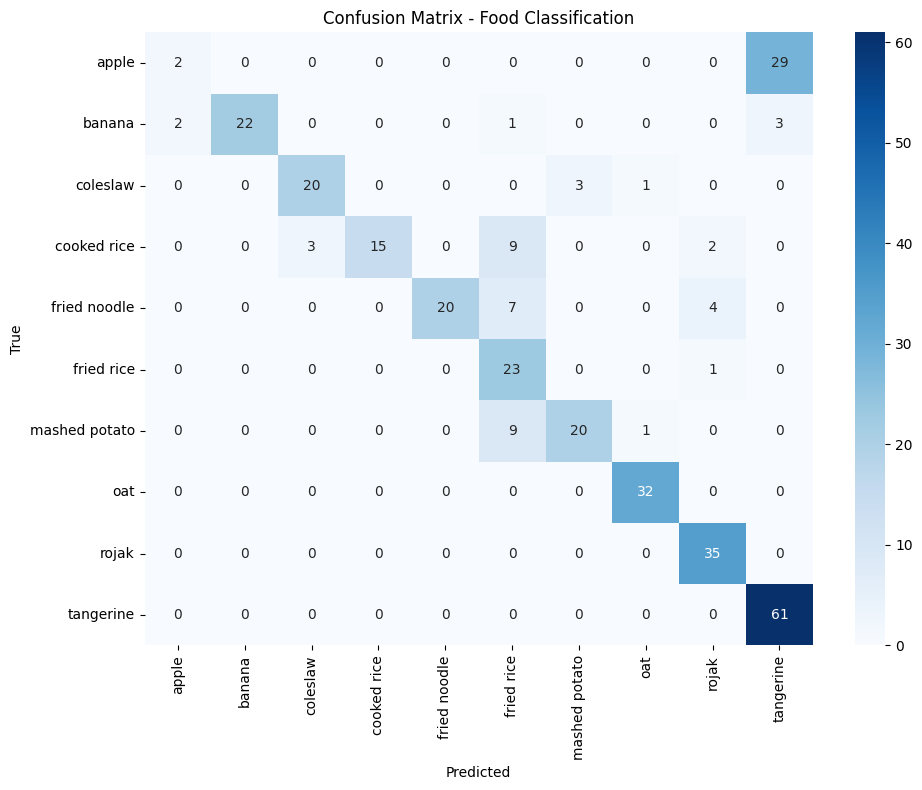


📈 Weight Prediction Performance:
MAE  = 19.24 grams
MSE  = 803.89
RMSE = 28.35 grams
MAPE = 18.02%


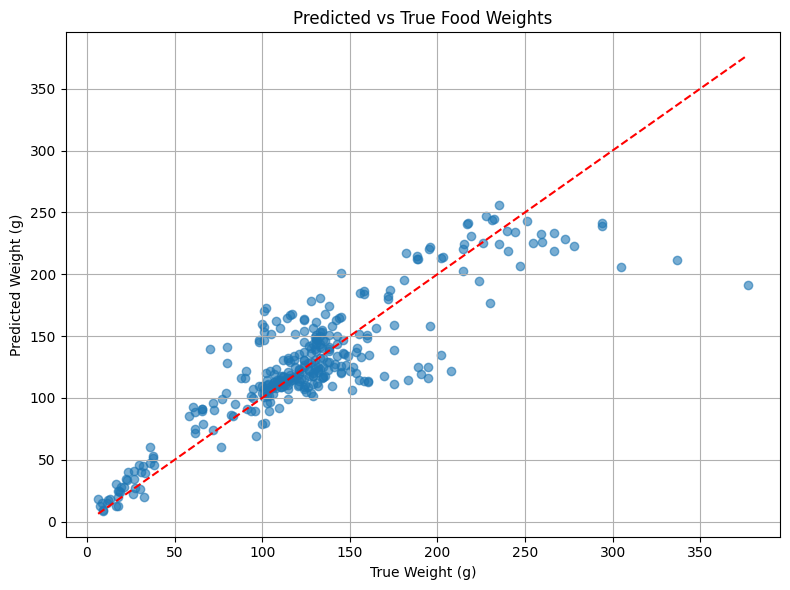

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# === Predict on Validation Set ===
pred_class_probs, pred_weights = model.predict(X_val)

# === Classification Evaluation ===
y_food_pred_labels = np.argmax(pred_class_probs, axis=1)
y_food_true_labels = np.argmax(y_food_val_onehot, axis=1)

print("\n📊 Classification Report (Food Type):")
print(classification_report(y_food_true_labels, y_food_pred_labels, target_names=label_encoder.classes_))

# === Confusion Matrix ===
cm = confusion_matrix(y_food_true_labels, y_food_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Food Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# === Regression Evaluation ===
mae = mean_absolute_error(y_weight_val, pred_weights)
mse = mean_squared_error(y_weight_val, pred_weights)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_weight_val, pred_weights)

print(f"\n📈 Weight Prediction Performance:")
print(f"MAE  = {mae:.2f} grams")
print(f"MSE  = {mse:.2f}")
print(f"RMSE = {rmse:.2f} grams")
print(f"MAPE = {mape * 100:.2f}%")

# === Scatter Plot of Predicted vs Actual Weights ===
plt.figure(figsize=(8, 6))
plt.scatter(y_weight_val, pred_weights, alpha=0.6)
plt.plot([min(y_weight_val), max(y_weight_val)],
         [min(y_weight_val), max(y_weight_val)], 'r--')
plt.xlabel("True Weight (g)")
plt.ylabel("Predicted Weight (g)")
plt.title("Predicted vs True Food Weights")
plt.grid(True)
plt.tight_layout()
plt.show()


##Testing (YOLO)

In [ ]:
!pip install ultralytics torch torchvision pandas pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import cv2
import os
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
class YOLOv11WithRegression(nn.Module):
    def __init__(self, yolo_model_path):
        super(YOLOv11WithRegression, self).__init__()
        self.yolo = YOLO(yolo_model_path)  # YOLOv11 model

        # Regression Head (MLP)
        self.regression_head = nn.Sequential(
            nn.Linear(5, 128),  # [x1, y1, x2, y2, area]
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # Output: weight
        )

    def forward(self, x):
        # YOLO Prediction
        results = self.yolo.predict(x, verbose=False)

        # Get Bounding Boxes
        boxes = results[0].boxes.xyxy  # (x1, y1, x2, y2)
        confidence = results[0].boxes.conf.unsqueeze(1)  # Confidence Score

        # Calculate Area (Width x Height)
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        area = area.unsqueeze(1)

        # Combine Features: [x1, y1, x2, y2, Area]
        bbox_features = torch.cat([boxes, area], dim=1).float()

        # Pass through Regression Head
        weight_pred = self.regression_head(bbox_features)

        return results, weight_pred



class FoodDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        try:
          img_name = os.path.join(self.image_dir, self.data.iloc[idx, 0] + ".jpg")
        except:
          img_name = os.path.join(self.image_dir, self.data.iloc[idx, 0] + ".JPG")
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        weight = float(self.data.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, weight


In [ ]:
# Set transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = FoodDataset(csv_file="/content/drive/My Drive/weights.csv",
                            image_dir='/content/drive/My Drive/3. Testing Datasets', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load YOLOv11 with Regression Head
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv11WithRegression("/content/drive/My Drive/yolo/segment/train/weights/best.pt").to(device)

# Define loss and optimizer
criterion_reg = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, weights in train_loader:
        images, weights = images.to(device), weights.to(device).float().view(-1, 1)

        optimizer.zero_grad()
        yolo_outputs, weight_preds = model(images)

        loss_reg = criterion_reg(weight_preds, weights)
        total_loss += loss_reg.item()

        loss_reg.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Regression Loss: {total_loss/len(train_loader):.4f}")

# Save updated model
torch.save(model.state_dict(), "yolo_with_regression.pt")


# **ArUco marker testing**

ArUco used:

aruco.DICT_5X5_100 ID[10] 5cm x 5cm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
print(cv2.__version__)  # Should be 4.x.x
print(dir(cv2.aruco))   # Should list 'Dictionary_get'

4.11.0
['ArucoDetector', 'Board', 'CORNER_REFINE_APRILTAG', 'CORNER_REFINE_CONTOUR', 'CORNER_REFINE_NONE', 'CORNER_REFINE_SUBPIX', 'CharucoBoard', 'CharucoDetector', 'CharucoParameters', 'DICT_4X4_100', 'DICT_4X4_1000', 'DICT_4X4_250', 'DICT_4X4_50', 'DICT_5X5_100', 'DICT_5X5_1000', 'DICT_5X5_250', 'DICT_5X5_50', 'DICT_6X6_100', 'DICT_6X6_1000', 'DICT_6X6_250', 'DICT_6X6_50', 'DICT_7X7_100', 'DICT_7X7_1000', 'DICT_7X7_250', 'DICT_7X7_50', 'DICT_APRILTAG_16H5', 'DICT_APRILTAG_16h5', 'DICT_APRILTAG_25H9', 'DICT_APRILTAG_25h9', 'DICT_APRILTAG_36H10', 'DICT_APRILTAG_36H11', 'DICT_APRILTAG_36h10', 'DICT_APRILTAG_36h11', 'DICT_ARUCO_MIP_36H12', 'DICT_ARUCO_MIP_36h12', 'DICT_ARUCO_ORIGINAL', 'DetectorParameters', 'Dictionary', 'Dictionary_getBitsFromByteList', 'Dictionary_getByteListFromBits', 'GridBoard', 'RefineParameters', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_native', 'drawDetectedCornersCharuco', 'drawDetectedDiamonds', 'drawDetectedMar

NameError: name 'gray' is not defined

In [ ]:
#calculate pixels from aruco marker

import cv2
from cv2 import aruco
from google.colab.patches import cv2_imshow as imshow
import numpy as np

# Load an image containing an ArUco marker
image_path = "/content/drive/My Drive/test2.jpg"  # Change this to your image path

def detect_aruco_marker(image_path, marker_length_cm):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #copy
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_100)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, _ = detector.detectMarkers(gray)
    #until here

    if ids is not None:
        # Calculate real-world scale (pixels per cm)
        marker_pixel_width = np.linalg.norm(corners[0][0][0] - corners[0][0][1])
        pixel_per_cm = marker_pixel_width / marker_length_cm
        return corners[0][0], pixel_per_cm  # Return marker corners and scale
    else:
        return None, None

print(detect_aruco_marker(image_path, 5))

(array([[1467., 1310.],
       [1452., 1045.],
       [1715., 1040.],
       [1730., 1321.]], dtype=float32), np.float32(53.08484))


In [ ]:
# Check whether aruco marker can be detected
import cv2
import os
from cv2 import aruco

# Folder containing images
folder_path = "/content/drive/My Drive/3. Testing Datasets"  # Change this to your folder path

# Use the new function to get a predefined dictionary
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)

# Define ArUco detector parameters
parameters = aruco.DetectorParameters()

# Create ArUco detector
aruco_detector = aruco.ArucoDetector(aruco_dict, parameters)

# Initialize counters
total_images = 0
images_with_aruco = 0
aruco_results = []

# Process each image in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
        total_images += 1
        image_path = os.path.join(folder_path, filename)

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to load {filename}. Skipping.")
            continue

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # List of dictionaries to try

        dictionaries = [
            aruco.DICT_4X4_50, aruco.DICT_4X4_100,aruco.DICT_4X4_1000,aruco.DICT_4X4_250, aruco.DICT_5X5_100, aruco.DICT_6X6_250,
            aruco.DICT_7X7_100, aruco.DICT_ARUCO_ORIGINAL
        ]

        for dict_type in dictionaries:
            aruco_dict = aruco.getPredefinedDictionary(dict_type)
            parameters = aruco.DetectorParameters()
            aruco_detector = aruco.ArucoDetector(aruco_dict, parameters)

            # Detect ArUco markers
            corners, ids, _ = aruco_detector.detectMarkers(gray)

            if ids is not None:
                print(f"Detected with dictionary {dict_type}: IDs = {ids.flatten()}")
                break  # Stop if detection is successful

        # Detect ArUco markers ///
        corners, ids, _ = aruco_detector.detectMarkers(gray)

        if ids is not None:
            images_with_aruco += 1
            detected_ids = ids.flatten().tolist()  # Convert to list
            aruco_results.append((filename, detected_ids))
        else:
            aruco_results.append((filename, []))

# Print summary results
print(f"Total images checked: {total_images}")
print(f"Images with ArUco markers detected: {images_with_aruco}")

for filename, detected_ids in aruco_results:
    if detected_ids:
        print(f"{filename}: Detected ArUco marker IDs {detected_ids}")
    else:
        print(f"{filename}: No ArUco marker detected")


# **Yolov11 training**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#yolov11
# !pip install roboflow
!pip install "ultralytics<=8.3.40" supervision roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 116.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 123.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211

In [ ]:
#Step required to load dataset (yolov11/yolov12)
from roboflow import Roboflow
rf = Roboflow(api_key="jdGaTSfWLxMAR3chcDGu")
project = rf.workspace("isdp-n2uvz").project("fyp_food-calorie-estimation-aovbr")
version = project.version(6)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to FYP_Food-Calorie-Estimation-6 in yolov11:: 100%|██████████| 6020/6020 [00:03<00:00, 1872.98it/s]


In [ ]:
# yolov11 train
!yolo task=detect mode=train model=yolo11s-seg.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

100% 19.7M/19.7M [00:00<00:00, 154MB/s] 
WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/FYP_Food-Calorie-Estimation-6/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=

In [ ]:
!cp -r runs/ /content/drive/MyDrive/

**YOLOv12 training (notes)**

In [ ]:
!git clone https://github.com/sunsmarterjie/yolov12
%cd yolov12
!pip install roboflow supervision flash-attn --upgrade -q
!pip install -r requirements.txt
!pip install -e .
!pip install --upgrade flash-attn

In [ ]:
#Step required to load dataset (yolov11/yolov12)
from roboflow import Roboflow
rf = Roboflow(api_key="jdGaTSfWLxMAR3chcDGu")
project = rf.workspace("isdp-n2uvz").project("fyp_food-calorie-estimation-aovbr")
version = project.version(1)
dataset = version.download("yolov11")

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=10,imgsz=640,plots=True)

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/yolov12/FYP_Food-Calorie-Estimation-1/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=Fa

100%|██████████| 5.26M/5.26M [00:00<00:00, 348MB/s]


AMP: checks passed ✅


train: Scanning /content/yolov12/FYP_Food-Calorie-Estimation-1/train/labels... 1210 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1210/1210 [00:00<00:00, 1373.30it/s]


train: New cache created: /content/yolov12/FYP_Food-Calorie-Estimation-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/yolov12/FYP_Food-Calorie-Estimation-1/valid/labels... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 494.74it/s]

val: New cache created: /content/yolov12/FYP_Food-Calorie-Estimation-1/valid/labels.cache


Plotting labels to /content/yolov12/runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolov12/runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      6.74G      2.678      5.541      4.173         10        640: 100%|██████████| 76/76 [00:48<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all         63         63   0.000102     0.0333      6e-05   8.85e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      6.83G      2.356      4.181      3.301         10        640: 100%|██████████| 76/76 [00:45<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         63         63    0.00235      0.741      0.278       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      6.67G      1.685      2.468      2.477         10        640: 100%|██████████| 76/76 [00:44<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         63         63      0.415      0.521      0.372      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      6.83G      1.304      1.507      2.031         10        640: 100%|██████████| 76/76 [00:43<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         63         63       0.63      0.794      0.859      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      6.83G      1.019      1.079      1.736         10        640: 100%|██████████| 76/76 [00:44<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         63         63      0.861      0.928      0.977      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      6.83G     0.8593     0.8443      1.533         10        640: 100%|██████████| 76/76 [00:43<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         63         63      0.919      0.843      0.974        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      6.83G     0.7448     0.7407      1.401         10        640: 100%|██████████| 76/76 [00:44<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         63         63      0.964      0.965      0.989      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      6.83G     0.6892     0.6761      1.323         10        640: 100%|██████████| 76/76 [00:44<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         63         63      0.946      0.984      0.992      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      6.83G     0.6558     0.6343      1.287         10        640: 100%|██████████| 76/76 [00:43<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         63         63      0.961       0.99      0.992       0.85



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      6.67G      0.586     0.5765      1.215         10        640: 100%|██████████| 76/76 [00:43<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         63         63      0.965      0.973      0.984      0.862



10 epochs completed in 0.134 hours.
Optimizer stripped from /content/yolov12/runs/detect/train3/weights/last.pt, 18.6MB
Optimizer stripped from /content/yolov12/runs/detect/train3/weights/best.pt, 18.6MB

Validating /content/yolov12/runs/detect/train3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,076,143 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


                   all         63         63      0.965      0.973      0.985       0.86
                 apple         12         12      0.975          1      0.995       0.93
                banana         17         17      0.936      0.864      0.943       0.63
          fried noodle          8          8      0.964          1      0.995      0.862
            fried rice         12         12      0.976          1      0.995      0.936
             tangerine         14         14      0.976          1      0.995      0.943
Speed: 0.2ms preprocess, 8.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/yolov12/runs/detect/train3


# **Pipeline to generate features for weight estimation model**

In [ ]:
!pip install "ultralytics<=8.3.40"
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.5/898.5 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 801.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

## Food area only

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from ultralytics import YOLO

# Load the trained YOLOv11 model
model = YOLO("/content/drive/My Drive/yolo/segment/train/weights/best.pt")  # Change this to your trained model path

# ArUco marker dictionary
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_100)

# Directory containing images
image_dir = "/content/drive/My Drive/3. Testing Datasets"  # Change to your folder path
output_excel = "/content/drive/My Drive/output.xlsx"  # Output file

# Function to detect ArUco marker and calculate pixels per cm
def detect_aruco_marker(image, marker_length_cm=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    parameters = cv2.aruco.DetectorParameters()

    corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=parameters)

    if ids is not None:
        marker_pixel_width = np.linalg.norm(corners[0][0][0] - corners[0][0][1])
        pixel_per_cm = marker_pixel_width / marker_length_cm
        return pixel_per_cm
    else:
        return None  # No ArUco detected

# Function to segment food and calculate area
def segment_food(image):
    results = model(image)
    masks = results[0].masks  # Extract segmentation masks

    if masks is None:
        return None, None  # No segmentation found

    food_mask = np.zeros(image.shape[:2], dtype=np.uint8)  # Initialize mask
    food_class = None

    for i, mask in enumerate(masks.data):  # Loop through detected objects
        mask_np = mask.cpu().numpy().astype(np.uint8) * 255  # Convert to uint8
        mask_resized = cv2.resize(mask_np, (image.shape[1], image.shape[0]))  # Resize to match image size
        food_mask = cv2.bitwise_or(food_mask, mask_resized)  # Combine masks

        food_class = results[0].names[int(results[0].boxes.cls[i])]  # Get food type

    return food_mask, food_class

# Function to calculate food area in cm²
def calculate_real_area(food_mask, pixel_per_cm):
    pixel_area = np.sum(food_mask > 0)  # Count white pixels
    real_area_cm2 = pixel_area / (pixel_per_cm ** 2)
    return real_area_cm2

# Process all images in the directory
results_list = []

for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Skipping {image_name}, unable to read.")
        continue

    print(f"Processing: {image_name}")

    # Detect ArUco marker
    pixel_per_cm = detect_aruco_marker(image)

    if pixel_per_cm is None:
        print(f"No ArUco marker detected in {image_name}. Skipping.")
        continue

    # Perform food segmentation
    food_mask, food_type = segment_food(image)

    if food_mask is None:
        print(f"No food detected in {image_name}. Skipping.")
        continue

    # Calculate food area
    food_area_cm2 = calculate_real_area(food_mask, pixel_per_cm)

    # Store results
    results_list.append([image_name, food_type, pixel_per_cm, food_area_cm2])

# Convert results to a DataFrame and save as Excel
df = pd.DataFrame(results_list, columns=["Image_name", "Food_type", "Pixels_per_cm", "Food_area"])
df.to_excel(output_excel, index=False)

print(f"Results saved to {output_excel}")


## Food area, food length and food width

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from ultralytics import YOLO

# Load the trained YOLOv11 model
model = YOLO("/content/drive/My Drive/yolo/segment/train/weights/best.pt")  # Your trained model path

# ArUco marker dictionary
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_100)

# Directory containing images
image_dir = "/content/drive/My Drive/3. Testing Datasets"  # Your image folder
output_excel = "/content/drive/My Drive/output.xlsx"  # Output Excel file

# Function to detect ArUco marker and calculate pixels per cm
def detect_aruco_marker(image, marker_length_cm=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    parameters = cv2.aruco.DetectorParameters()

    corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=parameters)

    if ids is not None:
        marker_pixel_width = np.linalg.norm(corners[0][0][0] - corners[0][0][1])
        pixel_per_cm = marker_pixel_width / marker_length_cm
        return pixel_per_cm
    else:
        return None

# Function to segment food and get food mask + bounding box
def segment_food(image):
    results = model(image)
    masks = results[0].masks
    boxes = results[0].boxes

    if masks is None:
        return None, None, None

    food_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    food_class = None
    food_bbox = None

    for i, mask in enumerate(masks.data):
        mask_np = mask.cpu().numpy().astype(np.uint8) * 255
        mask_resized = cv2.resize(mask_np, (image.shape[1], image.shape[0]))
        food_mask = cv2.bitwise_or(food_mask, mask_resized)

        food_class = results[0].names[int(boxes.cls[i])]
        food_bbox = boxes.xyxy[i].cpu().numpy()  # Bounding Box [x1, y1, x2, y2]

    return food_mask, food_class, food_bbox

# Function to calculate food area in cm²
def calculate_real_area(food_mask, pixel_per_cm):
    pixel_area = np.sum(food_mask > 0)
    real_area_cm2 = pixel_area / (pixel_per_cm ** 2)
    return real_area_cm2

# Function to calculate width and length in cm from bounding box
def calculate_width_length(bbox, pixel_per_cm):
    x1, y1, x2, y2 = bbox
    width_pixel = abs(x2 - x1)
    length_pixel = abs(y2 - y1)

    width_cm = width_pixel / pixel_per_cm
    length_cm = length_pixel / pixel_per_cm
    return width_cm, length_cm

# Process all images in the directory
results_list = []

for image_name in os.listdir(image_dir):
    image_path = os.path.join(image_dir, image_name)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Skipping {image_name}, unable to read.")
        continue

    print(f"Processing: {image_name}")

    # Detect ArUco marker
    pixel_per_cm = detect_aruco_marker(image)

    if pixel_per_cm is None:
        print(f"No ArUco marker detected in {image_name}. Skipping.")
        continue

    # Perform food segmentation
    food_mask, food_type, food_bbox = segment_food(image)

    if food_mask is None:
        print(f"No food detected in {image_name}. Skipping.")
        continue

    # Calculate food area
    food_area_cm2 = calculate_real_area(food_mask, pixel_per_cm)

    # Calculate Width and Length
    if food_bbox is not None:
        food_width, food_length = calculate_width_length(food_bbox, pixel_per_cm)
    else:
        food_width, food_length = None, None

    # Store Results
    results_list.append([image_name, food_type, pixel_per_cm, food_area_cm2, food_width, food_length])

# Convert results to DataFrame and save to Excel
df = pd.DataFrame(results_list, columns=["Image_name", "Food_type", "Pixels_per_cm", "Food_area", "Food_width", "Food_length"])
df.to_excel(output_excel, index=False)

print(f"Results saved to {output_excel}")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Processing: Banana_1b.JPG

0: 640x480 1 banana, 982.8ms
Speed: 9.9ms preprocess, 982.8ms inference, 40.0ms postprocess per image at shape (1, 3, 640, 480)
Processing: Banana_1d.JPG

0: 640x480 1 banana, 895.0ms
Speed: 5.9ms preprocess, 895.0ms inference, 7.8ms postprocess per image at shape (1, 3, 640, 480)
Processing: Banana_1e.JPG

0: 640x480 1 banana, 576.8ms
Speed: 6.5ms preprocess, 576.8ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 480)
Processing: Banana_2b.JPG

0: 640x480 1 banana, 580.0ms
Speed: 5.8ms preprocess, 580.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)
Processing: Banana_2a.JPG

0: 640x480 1 banana, 582.1ms
Speed: 5.5ms pre

## **Full Features**

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
from ultralytics import YOLO

# Load the trained YOLOv11 model
model = YOLO("/content/drive/My Drive/yolov11/segment/train/weights/best.pt")  # Your trained model path

# ArUco marker dictionary
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_100)

# Directory containing images
image_dir = "/content/drive/My Drive/(10)Coleslaw"  # Your image folder
output_excel = "/content/drive/My Drive/output.xlsx"  # Output Excel file

# Function to detect ArUco marker and calculate pixels per cm
def detect_aruco_marker(image, marker_length_cm=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #copy
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(ARUCO_DICT, parameters)
    corners, ids, _ = detector.detectMarkers(gray)
    #until here
    # parameters = cv2.aruco.DetectorParameters()

    # corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=parameters)

    if ids is not None:
        marker_pixel_width = np.linalg.norm(corners[0][0][0] - corners[0][0][1])
        pixel_per_cm = marker_pixel_width / marker_length_cm
        return pixel_per_cm
    else:
        return None

# Function to segment food and get food mask + bounding box
def segment_food(image):
    results = model(image)
    masks = results[0].masks
    boxes = results[0].boxes

    if masks is None:
        return None, None, None

    food_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    food_class = None
    food_bbox = None

    for i, mask in enumerate(masks.data):
        mask_np = mask.cpu().numpy().astype(np.uint8) * 255
        mask_resized = cv2.resize(mask_np, (image.shape[1], image.shape[0]))
        food_mask = cv2.bitwise_or(food_mask, mask_resized)

        food_class = results[0].names[int(boxes.cls[i])]
        food_bbox = boxes.xyxy[i].cpu().numpy()  # Bounding Box [x1, y1, x2, y2]

    return food_mask, food_class, food_bbox

# Function to calculate food area in cm²
def calculate_real_area(food_mask, pixel_per_cm):
    pixel_area = np.sum(food_mask > 0)
    real_area_cm2 = pixel_area / (pixel_per_cm ** 2)
    return real_area_cm2

# Function to calculate width and length in cm from bounding box
def calculate_width_length(bbox, pixel_per_cm):
    x1, y1, x2, y2 = bbox
    width_pixel = abs(x2 - x1)
    length_pixel = abs(y2 - y1)

    width_cm = width_pixel / pixel_per_cm
    length_cm = length_pixel / pixel_per_cm
    return width_cm, length_cm

# Function to extract additional shape-based features
def calculate_shape_features(food_mask):
    contours, _ = cv2.findContours(food_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None, None, None, None, None, None

    cnt = max(contours, key=cv2.contourArea)  # Largest contour
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h != 0 else 0
    extent = area / (w * h) if (w * h) != 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area != 0 else 0

    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter != 0 else 0

    return aspect_ratio, extent, solidity, circularity, area, perimeter

# Function to estimate volume (assuming ellipsoid shape)
def estimate_volume(width_cm, length_cm):
    volume_cm3 = (4/3) * np.pi * (width_cm / 2) * (length_cm / 2) * (min(width_cm, length_cm) / 2)
    return volume_cm3

# Function to compute color-based features (Mean RGB values)
def extract_color_features(image, food_mask):
    masked_image = cv2.bitwise_and(image, image, mask=food_mask)
    mean_color = cv2.mean(masked_image, mask=food_mask)[:3]  # Get RGB mean values
    return mean_color

# Function to compute edge density
def compute_edge_density(food_mask):
    edges = cv2.Canny(food_mask, 100, 200)
    edge_density = np.sum(edges) / np.sum(food_mask > 0) if np.sum(food_mask > 0) != 0 else 0
    return edge_density

# Process all images in the directory
results_list = []

for root, dirs, files in os.walk(image_dir):
    for image_name in files:
        if not image_name.lower().endswith(('.jpg', '.jpeg', '.png')):  # skip non-image files
            continue

        image_path = os.path.join(root, image_name)
        subfolder_name = os.path.basename(root)  # Get the last directory name (e.g., Apple_1)\

        image = cv2.imread(image_path)

        if image is None:
            print(f"Skipping {image_name}, unable to read.")
            continue

        print(f"Processing: {image_name}")

        # Detect ArUco marker
        pixel_per_cm = detect_aruco_marker(image)

        if pixel_per_cm is None:
            print(f"No ArUco marker detected in {image_name}. Skipping.")
            continue

        # Perform food segmentation
        food_mask, food_type, food_bbox = segment_food(image)

        if food_mask is None:
            print(f"No food detected in {image_name}. Skipping.")
            continue

        # Calculate food area
        food_area_cm2 = calculate_real_area(food_mask, pixel_per_cm)

        # Calculate Width and Length
        if food_bbox is not None:
            food_width, food_length = calculate_width_length(food_bbox, pixel_per_cm)
        else:
            food_width, food_length = None, None

        # Compute additional shape features
        aspect_ratio, extent, solidity, circularity, contour_area, perimeter = calculate_shape_features(food_mask)

        # Compute estimated volume
        volume_cm3 = estimate_volume(food_width, food_length) if food_width and food_length else None

        # Extract color features (Mean RGB)
        mean_r, mean_g, mean_b = extract_color_features(image, food_mask)

        # Compute edge density
        edge_density = compute_edge_density(food_mask)

        # Store Results
        results_list.append([
            image_name, subfolder_name, food_type, pixel_per_cm, food_area_cm2, food_width, food_length,
            aspect_ratio, extent, solidity, circularity, volume_cm3, mean_r, mean_g, mean_b, edge_density
        ])

# Convert results to DataFrame and save to Excel
df_columns = [
    "Image_name", "Subfolder", "Food_type", "Pixels_per_cm", "Food_area", "Food_width", "Food_length",
    "Aspect_Ratio", "Extent", "Solidity", "Circularity", "Estimated_Volume",
    "Mean_R", "Mean_G", "Mean_B", "Edge_Density"
]

# df = pd.DataFrame(results_list, columns=df_columns)
# df.to_excel(output_excel, index=False)

# Create DataFrame from current run
df_new = pd.DataFrame(results_list, columns=df_columns)

if os.path.exists(output_excel):
    df_existing = pd.read_excel(output_excel)
    df_combined = pd.concat([df_existing, df_new], ignore_index=True)
else:
    df_combined = df_new

df_combined.to_excel(output_excel, index=False)

print(f"Results saved to {output_excel}")


Processing: photo_6289662714171214024_y.jpg

0: 640x480 1 coleslaw, 1649.6ms
Speed: 18.3ms preprocess, 1649.6ms inference, 22.5ms postprocess per image at shape (1, 3, 640, 480)
Processing: photo_6289662714171214025_y.jpg

0: 640x480 1 coleslaw, 638.0ms
Speed: 4.6ms preprocess, 638.0ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)
Processing: photo_6289662714171214023_y.jpg

0: 640x480 1 coleslaw, 659.2ms
Speed: 4.4ms preprocess, 659.2ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 480)
Processing: photo_6289662714171214157_y.jpg

0: 640x480 1 coleslaw, 621.5ms
Speed: 4.1ms preprocess, 621.5ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)
Processing: photo_6289662714171214158_y.jpg

0: 640x480 1 coleslaw, 670.6ms
Speed: 5.2ms preprocess, 670.6ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 480)
Processing: photo_6289662714171214156_y.jpg

0: 640x480 1 coleslaw, 727.5ms
Speed: 3.9ms preprocess, 727.5ms inference, 6.4ms 

##Annotate image to show output

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow

# Load the trained YOLOv11 model
model = YOLO("/content/drive/My Drive/yolov11-v3/segment/train/weights/best.pt")  # Your trained model path

# ArUco marker dictionary
ARUCO_DICT = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_100)

# Path to the single image
image_path = "/content/drive/My Drive/test2.jpg"  # Change this to your image file

# Function to detect ArUco marker and calculate pixels per cm
def detect_aruco_marker(image, marker_length_cm=5):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(ARUCO_DICT, parameters)
    corners, ids, _ = detector.detectMarkers(gray)

    # parameters = cv2.aruco.DetectorParameters()

    # corners, ids, _ = cv2.aruco.detectMarkers(gray, ARUCO_DICT, parameters=parameters)

    if ids is not None:
        marker_pixel_width = np.linalg.norm(corners[0][0][0] - corners[0][0][1])
        pixel_per_cm = marker_pixel_width / marker_length_cm
        return pixel_per_cm
    else:
        return None

# Function to segment food and get food mask + bounding box
def segment_food(image):
    results = model(image)
    masks = results[0].masks
    boxes = results[0].boxes

    if masks is None:
        return None, None, None

    food_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    food_class = None
    food_bbox = None

    for i, mask in enumerate(masks.data):
        mask_np = mask.cpu().numpy().astype(np.uint8) * 255
        mask_resized = cv2.resize(mask_np, (image.shape[1], image.shape[0]))
        food_mask = cv2.bitwise_or(food_mask, mask_resized)

        food_class = results[0].names[int(boxes.cls[i])]
        food_bbox = boxes.xyxy[i].cpu().numpy()  # Bounding Box [x1, y1, x2, y2]

    return food_mask, food_class, food_bbox

# Function to calculate food area in cm²
def calculate_real_area(food_mask, pixel_per_cm):
    pixel_area = np.sum(food_mask > 0)
    real_area_cm2 = pixel_area / (pixel_per_cm ** 2)
    return real_area_cm2

# Function to calculate width and length in cm from bounding box
def calculate_width_length(bbox, pixel_per_cm):
    x1, y1, x2, y2 = bbox
    width_pixel = abs(x2 - x1)
    length_pixel = abs(y2 - y1)

    width_cm = width_pixel / pixel_per_cm
    length_cm = length_pixel / pixel_per_cm
    return width_cm, length_cm

# Load and process the image
image = cv2.imread(image_path)

if image is None:
    print(f"Error: Unable to read {image_path}")
else:
    print(f"Processing: {image_path}")

    # Detect ArUco marker
    pixel_per_cm = detect_aruco_marker(image)

    if pixel_per_cm is None:
        print("No ArUco marker detected. Skipping image.")
    else:
        # Perform food segmentation
        food_mask, food_type, food_bbox = segment_food(image)

        if food_mask is None:
            print("No food detected. Skipping image.")
        else:
            # Overlay mask on image
            mask_colored = cv2.merge([food_mask, np.zeros_like(food_mask), np.zeros_like(food_mask)])
            image = cv2.addWeighted(image, 1, mask_colored, 0.5, 0)

            # Calculate food area
            food_area_cm2 = calculate_real_area(food_mask, pixel_per_cm)

            # Calculate Width and Length
            if food_bbox is not None:
                food_width, food_length = calculate_width_length(food_bbox, pixel_per_cm)

                # Draw bounding box around the food
                x1, y1, x2, y2 = map(int, food_bbox)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 4)

                # # Define font and size
                # font = cv2.FONT_HERSHEY_SIMPLEX
                # font_scale = 5 #1.2
                # font_thickness = 3
                # text_color = (255, 255, 255)
                # bg_color = (0, 0, 0)

                # # Add width at the bottom of the bounding box
                # width_text = f"W: {food_width:.2f} cm"
                # (tw, th), _ = cv2.getTextSize(width_text, font, font_scale, font_thickness)
                # cv2.rectangle(image, (x1, y2), (x1 + tw + 10, y2 + th + 10), bg_color, -1)
                # cv2.putText(image, width_text, (x1 + 5, y2 + th), font, font_scale, text_color, font_thickness)

                # # Add length on the right side of the bounding box
                # length_text = f"L: {food_length:.2f} cm"
                # (tlw, tlh), _ = cv2.getTextSize(length_text, font, font_scale, font_thickness)
                # cv2.rectangle(image, (x2, y1), (x2 + tlw + 10, y1 + tlh + 10), bg_color, -1)
                # cv2.putText(image, length_text, (x2 + 5, y1 + tlh), font, font_scale, text_color, font_thickness)

                # # Combine food type and area
                # area_text = f"{food_type} | Area: {food_area_cm2:.2f} cm2"
                # (ta, tb), _ = cv2.getTextSize(area_text, font, font_scale, font_thickness)
                # cv2.rectangle(image, (x1, y1 - tb - 10), (x1 + ta + 10, y1), bg_color, -1)
                # cv2.putText(image, area_text, (x1 + 5, y1 - 5), font, font_scale, text_color, font_thickness)

                # Show the annotated image
                cv2_imshow(image)
                cv2.waitKey(0)  # Wait for key press
                cv2.destroyAllWindows()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


KeyboardInterrupt: 

# **Build Weight Estimation Model**

## Method 1 (XGBoost)

Model Performance:
MAE: 6.67
MSE: 97.27
RMSE: 9.86
MAPE: 5.28%

Feature Importance:
Pixels_per_cm: 0.0074
Food_area: 0.0907
Food_width: 0.0048
Food_length: 0.0114
Aspect_Ratio: 0.0006
Extent: 0.0009
Solidity: 0.0013
Circularity: 0.0008
Estimated_Volume: 0.0963
Mean_R: 0.0008
Mean_G: 0.0017
Mean_B: 0.0045
Edge_Density: 0.0205
Food_type_apple: 0.0367
Food_type_banana: 0.0018
Food_type_coleslaw: 0.0047
Food_type_cooked rice: 0.0004
Food_type_fried noodle: 0.0219
Food_type_fried rice: 0.0015
Food_type_mashed potato: 0.0031
Food_type_oat: 0.4693
Food_type_rojak: 0.2186
Food_type_tangerine: 0.0003


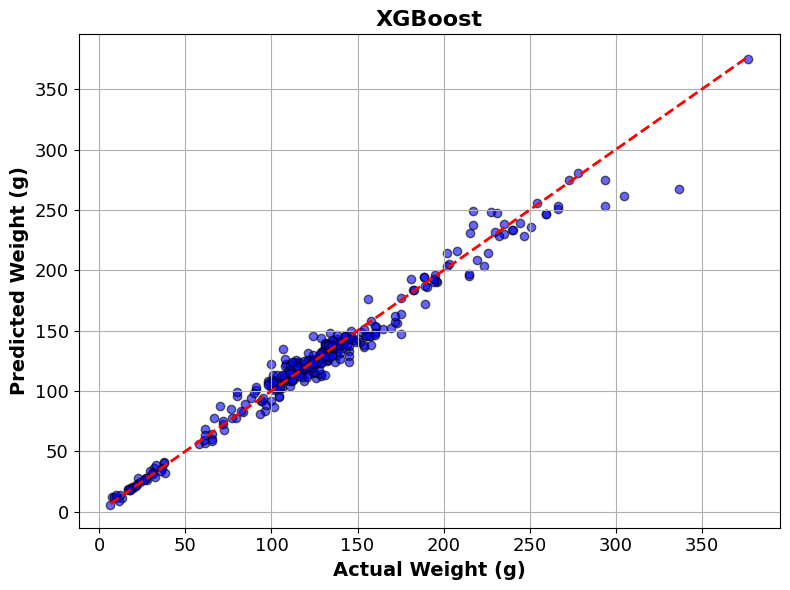

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = "/content/drive/My Drive/output.xlsx"  # Change to your file path
df = pd.read_excel(file_path)

# Drop Image_name (not needed)
df = df.drop(columns=["Image_name","Subfolder"])

# Convert Food_type to numerical representation (One-Hot Encoding)
encoder = OneHotEncoder(sparse_output=False)
food_type_encoded = encoder.fit_transform(df[['Food_type']])

# Convert to DataFrame and concatenate with original data
food_type_df = pd.DataFrame(food_type_encoded, columns=encoder.get_feature_names_out(['Food_type']))
df = pd.concat([df.drop(columns=['Food_type']), food_type_df], axis=1)
df = df.dropna()  # Drop any rows with NaN values

# Define features (X) and target variable (y)
X = df.drop(columns=["Food_weight"])  # Input features
y = df["Food_weight"]  # Target variable

# Split data into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (mae / y_test.mean()) * 100

print(f"Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Feature importance
importance = xgb_model.feature_importances_  # Changed from model to xgb_model
feature_names = X.columns
print("\nFeature Importance:")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {importance[i]:.4f}")

import matplotlib.pyplot as plt

# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Weight (g)", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Weight (g)", fontsize=14, fontweight='bold')
plt.title("XGBoost", fontsize=16, fontweight='bold')
plt.xticks(fontsize=13)  # or whatever size you like
plt.yticks(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#save model
xgb_model.save_model('/content/drive/MyDrive/xgboost_model.json')

In [ ]:
#save encoder used in training
import joblib

# Save encoder to file
joblib.dump(encoder, "/content/drive/My Drive/encoder.pkl")

['/content/drive/My Drive/encoder.pkl']

In [ ]:
# Grid Search CV
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

# Reload dataset
file_path = "/content/drive/My Drive/output.xlsx"
df = pd.read_excel(file_path)
df = df.dropna()  # Drop any rows with NaN values

# Drop Image_name column since it's not needed for training
df_processed = df.drop(columns=["Image_name","Subfolder"])

# Label Encode 'Food_type' since it is categorical (non-ordinal)
le = LabelEncoder()
df_processed["Food_type"] = le.fit_transform(df_processed["Food_type"])  # Converts Apple → 0, Banana → 1, etc.

# Split dataset
X = df_processed.drop(columns=["Food_weight"])  # Features
y = df_processed["Food_weight"]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model with enable_categorical=True
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", enable_categorical=True, random_state=42)

# Define parameter grid for tuning (simplified for faster execution)
param_grid = {
    "n_estimators": [100, 150],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 6],
}

# Perform GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, scoring="neg_mean_absolute_error", cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best model from grid search
best_xgb = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on test data
y_pred = best_xgb.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Best Parameters:", best_params)
# Print best parameters and model performance
print("\nModel Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Feature Importance
importance = best_xgb.feature_importances_
feature_names = X.columns
print("\nFeature Importance:")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {importance[i]:.4f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 150}

Model Performance:
MAE: 6.56
MSE: 93.32
RMSE: 9.66
MAPE: 5.92%

Feature Importance:
Food_type: 0.0905
Pixels_per_cm: 0.0185
Food_area: 0.3318
Food_width: 0.0253
Food_length: 0.0567
Aspect_Ratio: 0.0023
Extent: 0.0032
Solidity: 0.0056
Circularity: 0.0027
Estimated_Volume: 0.1966
Mean_R: 0.1707
Mean_G: 0.0143
Mean_B: 0.0168
Edge_Density: 0.0652


## Method 2 (CatBoost)

In [ ]:
 !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


0:	learn: 63.1778172	total: 7.08ms	remaining: 3.53s
1:	learn: 60.9200222	total: 11.8ms	remaining: 2.93s
2:	learn: 58.8046368	total: 16ms	remaining: 2.66s
3:	learn: 56.8118626	total: 20.2ms	remaining: 2.51s
4:	learn: 54.9259670	total: 24.5ms	remaining: 2.43s
5:	learn: 52.9019789	total: 28.9ms	remaining: 2.38s
6:	learn: 51.1764295	total: 33.3ms	remaining: 2.34s
7:	learn: 49.3322696	total: 37.5ms	remaining: 2.31s
8:	learn: 47.8098637	total: 41.7ms	remaining: 2.28s
9:	learn: 46.2185475	total: 46ms	remaining: 2.25s
10:	learn: 44.5875972	total: 50.2ms	remaining: 2.23s
11:	learn: 43.1932607	total: 54.5ms	remaining: 2.22s
12:	learn: 41.7528252	total: 59ms	remaining: 2.21s
13:	learn: 40.5808622	total: 63.4ms	remaining: 2.2s
14:	learn: 39.3860928	total: 67.6ms	remaining: 2.18s
15:	learn: 38.1296897	total: 72.1ms	remaining: 2.18s
16:	learn: 37.0577079	total: 76.4ms	remaining: 2.17s
17:	learn: 36.0796591	total: 80.8ms	remaining: 2.16s
18:	learn: 34.9830252	total: 85.1ms	remaining: 2.15s
19:	learn:

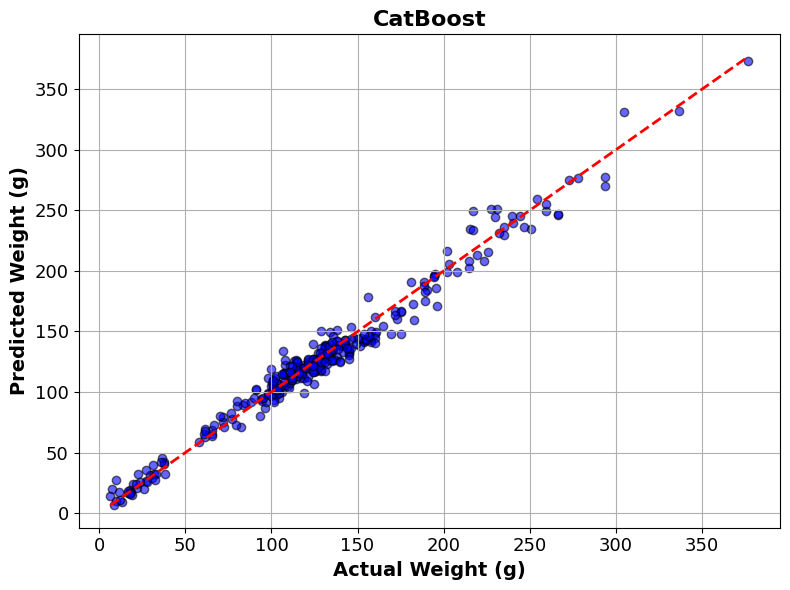

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

# Reload dataset
file_path = "/content/drive/My Drive/output.xlsx"
df = pd.read_excel(file_path)
df = df.dropna()  # Drop any rows with NaN values

# Drop Image_name column since it's not needed for training
df_processed = df.drop(columns=["Image_name","Subfolder"])

# Label Encode 'Food_type' since it is categorical (non-ordinal)
le = LabelEncoder()
df_processed["Food_type"] = le.fit_transform(df_processed["Food_type"])  # Converts Apple → 0, Banana → 1, etc.

# Split dataset
X = df_processed.drop(columns=["Food_weight"])  # Features
y = df_processed["Food_weight"]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform GridSearchCV
cat_boost = CatBoostRegressor(cat_features=[0], iterations=500, depth=6, learning_rate=0.05)
cat_boost.fit(X_train, y_train)

# Predict on test data
y_pred = cat_boost.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print best parameters and model performance
print("\nModel Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Feature Importance
importance = cat_boost.feature_importances_
feature_names = X.columns
print("\nFeature Importance:")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {importance[i]:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual Weight (g)", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Weight (g)", fontsize=14, fontweight='bold')
plt.title("CatBoost", fontsize=16, fontweight='bold')
plt.xticks(fontsize=13)  # or whatever size you like
plt.yticks(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder

# Reload dataset
file_path = "/content/drive/My Drive/output.xlsx"
df = pd.read_excel(file_path)
df = df.dropna()  # Drop any rows with NaN values

# Drop Image_name column since it's not needed for training
df_processed = df.drop(columns=["Image_name","Subfolder"])

# Label Encode 'Food_type' since it is categorical (non-ordinal)
le = LabelEncoder()
df_processed["Food_type"] = le.fit_transform(df_processed["Food_type"])

# Split dataset
X = df_processed.drop(columns=["Food_weight"])  # Features
y = df_processed["Food_weight"]  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to CatBoost Pool format
train_pool = Pool(X_train, y_train, cat_features=[X.columns.get_loc("Food_type")])
test_pool = Pool(X_test, y_test, cat_features=[X.columns.get_loc("Food_type")])

# Define CatBoost model with optimized parameters
cat_model = CatBoostRegressor(
    iterations=1000,             # More boosting rounds for better accuracy
    learning_rate=0.03,          # Lower LR for better generalization
    depth=8,                     # Increased depth for better feature learning
    l2_leaf_reg=3,               # Regularization to reduce overfitting
    loss_function="MAE",         # Mean Absolute Error is robust to outliers
    cat_features=[X.columns.get_loc("Food_type")],
    random_seed=42,
    verbose=100,                 # Display progress every 100 iterations
    early_stopping_rounds=50     # Stop training early if no improvement
)

# Train CatBoost model
cat_model.fit(train_pool, eval_set=test_pool)

# Predict on test data
y_pred = cat_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

# Print best parameters and model performance
print("\nModel Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Feature Importance
importance = cat_model.get_feature_importance()
feature_names = X.columns
print("\nFeature Importance:")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {importance[i]:.4f}")


0:	learn: 41.7939086	test: 39.9816081	best: 39.9816081 (0)	total: 50.8ms	remaining: 50.8s
100:	learn: 11.1094868	test: 10.6842134	best: 10.6842134 (100)	total: 1.83s	remaining: 16.3s
200:	learn: 7.3790012	test: 8.0174408	best: 8.0174408 (200)	total: 3.73s	remaining: 14.8s
300:	learn: 5.8358081	test: 7.3944345	best: 7.3944345 (300)	total: 8.22s	remaining: 19.1s
400:	learn: 4.9058707	test: 7.0607112	best: 7.0607112 (400)	total: 10.3s	remaining: 15.4s
500:	learn: 4.2103301	test: 6.9139027	best: 6.9048908 (499)	total: 11.7s	remaining: 11.7s
600:	learn: 3.7061324	test: 6.7930727	best: 6.7930727 (600)	total: 13.1s	remaining: 8.71s
700:	learn: 3.3086972	test: 6.7512498	best: 6.7442592 (693)	total: 14.5s	remaining: 6.2s
800:	learn: 2.9964489	test: 6.6953627	best: 6.6947417 (798)	total: 15.9s	remaining: 3.95s
900:	learn: 2.7645566	test: 6.6580062	best: 6.6576411 (898)	total: 17.3s	remaining: 1.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 6.656195512
bestIteration = 905



## Method 3 (LightGBM)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3335
[LightGBM] [Info] Number of data points in the train set: 1296, number of used features: 23
[LightGBM] [Info] Start training from score 129.552160
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

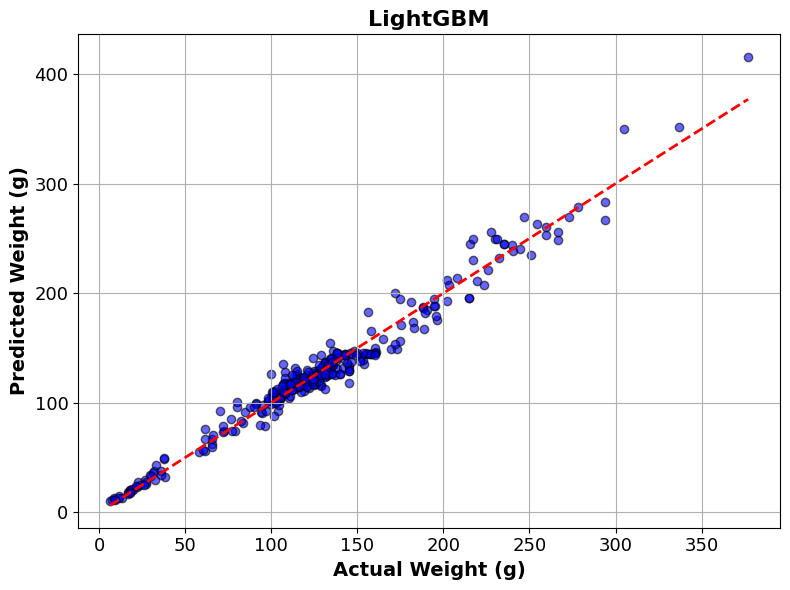

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = "/content/drive/My Drive/output.xlsx"  # Change to your file path
df = pd.read_excel(file_path)

# Drop Image_name (not needed)
df = df.drop(columns=["Image_name","Subfolder"])

# Convert Food_type to numerical representation (One-Hot Encoding)
encoder = OneHotEncoder(sparse_output=False)
food_type_encoded = encoder.fit_transform(df[['Food_type']])

# Convert to DataFrame and concatenate with original data
food_type_df = pd.DataFrame(food_type_encoded, columns=encoder.get_feature_names_out(['Food_type']))
df = pd.concat([df.drop(columns=['Food_type']), food_type_df], axis=1)
df = df.dropna()  # Drop any rows with NaN values

# Define features (X) and target variable (y)
X = df.drop(columns=["Food_weight"])  # Input features
y = df["Food_weight"]  # Target variable

# Split data into training & testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train LightGBM model
lgb_model = lgb.LGBMRegressor(objective="regression", n_estimators=100, learning_rate=0.1, max_depth=6)
lgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = lgb_model.predict(X_test)

# Evaluate model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = (mae / y_test.mean()) * 100

print(f"Model Performance:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Feature importance
importance = lgb_model.feature_importances_
feature_names = X.columns
print("\nFeature Importance:")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {importance[i]:.4f}")


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Weight (g)", fontsize=14, fontweight='bold')
plt.ylabel("Predicted Weight (g)", fontsize=14, fontweight='bold')
plt.title("LightGBM", fontsize=16, fontweight='bold')
plt.xticks(fontsize=13)  # or whatever size you like
plt.yticks(fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()
